# Part 2.3: Markov Decision Processes (MDP)

Welcome to Part 2.3! This is where everything comes together. We've learned about Markov chains (state evolution) and MRPs (adding rewards). Now we add the final piece: actions and decision-making. This completes the mathematical framework that underpins all of reinforcement learning.

## What This Notebook Covers
- Markov Decision Processes (MDPs): the full RL framework
- Policies: how agents choose actions
- State-value functions V^π(s) and action-value functions Q^π(s,a)
- Bellman expectation equations for policy evaluation

## What This Notebook Does NOT Cover

| Topic | Why Not Here | Where to Find It |
|-------|--------------|------------------|
| **Optimal policies and value functions** | That's a big topic deserving its own notebook | Part 2.4 covers V*, Q*, Bellman optimality equations, and finding optimal policies |
| **RL algorithms** | We derive the Bellman equations but don't implement iterative algorithms | Part 3 covers policy iteration, value iteration, and dynamic programming |
| **Model-free methods** | We assume we know the MDP model (transitions and rewards) | Parts 4-5 cover Q-learning, SARSA, and learning without knowing the model |

## Prerequisites
- Completed 02_1 (Markov chains) and 02_2 (MRPs)
- Understanding of probability and expectation

## How to Read This Notebook
1. **See how actions change everything** - MDPs add choice to what you learned in MRPs
2. **Understand both value functions** - V(s) and Q(s,a) give different perspectives
3. **Master the Bellman expectation equations** - These are the foundation of RL algorithms

Let's begin!

---
## Setup

First, let's import the necessary libraries.

> **Note:** If you're running this in a fresh environment, uncomment and run the installation cell below first.

In [ ]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

In [ ]:
# Helper function to visualize the FrozenLake grid
def visualize_frozenlake(env, current_state=None, title="FrozenLake Environment"):
    """Visualize the FrozenLake grid with the current state highlighted."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            color = colors.get(cell, 'white')
            state_idx = i * ncol + j
            if current_state is not None and state_idx == current_state:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True, 
                                     facecolor='yellow', edgecolor='black', linewidth=2)
            else:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                   ha='center', va='center', fontsize=20, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='S: Start'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='F: Frozen (safe)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='H: Hole (game over)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='G: Goal (reward!)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', linewidth=2, label='Current position')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    return fig, ax


def visualize_value_function(V, title="State Value Function V(s)"):
    """Visualize the value function as a heatmap on the FrozenLake grid."""
    V_grid = V.reshape((4, 4))
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    im = sns.heatmap(V_grid, annot=True, fmt=".3f", cmap="Greens", 
                     cbar_kws={'label': 'Value'}, ax=ax,
                     linewidths=0.5, linecolor='gray')
    
    labels = [['S', 'F', 'F', 'F'],
              ['F', 'H', 'F', 'H'],
              ['F', 'F', 'F', 'H'],
              ['H', 'F', 'F', 'G']]
    
    for i in range(4):
        for j in range(4):
            ax.text(j + 0.5, i + 0.15, labels[i][j], 
                   ha='center', va='center', fontsize=10, 
                   color='red' if labels[i][j] == 'H' else 'blue',
                   fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    plt.tight_layout()
    return fig, ax

---
# 1. Markov Decision Process (MDP)

A **Markov Decision Process** adds **actions** to the MRP. Now the agent can **choose** what to do, rather than following a fixed behavior.

This is the full framework for reinforcement learning!

## Definition

An MDP is a tuple $(S, A, P, R, \gamma)$ where:
- $S$ is a finite set of **states**
- $A$ is a finite set of **actions**
- $P$ is the state transition probability: $P^a_{ss'} = P[S_{t+1} = s' | S_t = s, A_t = a]$
- $R$ is the reward function: $R^a_s = \mathbb{E}[R_{t+1} | S_t = s, A_t = a]$
- $\gamma$ is a discount factor, $\gamma \in [0, 1]$

**Transition probability plain English:** "The probability of transitioning from state s to state s-prime when taking action a equals the probability that the next state is s-prime, given that the current state is s and the action is a."

**Formula components for $P^a_{ss'}$:**
- $P^a_{ss'}$ = the transition probability from $s$ to $s'$ when taking action $a$ (read as "P super a sub s s-prime")
- $P[\cdot]$ = probability of the event in brackets
- $S_{t+1}$ = the state random variable at the next time step
- $s'$ = a specific next state value
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at the current time step
- $s$ = a specific current state value
- $A_t$ = the action random variable at the current time step
- $a$ = a specific action value

**Reward function plain English:** "The expected reward for state s and action a equals the expected value of the next reward, given that the current state is s and the current action is a."

**Formula components for $R^a_s$:**
- $R^a_s$ = the expected reward for state $s$ when taking action $a$ (read as "R super a sub s")
- $\mathbb{E}[\cdot]$ = the expected value (average) of what's in brackets
- $R_{t+1}$ = the reward random variable at the next time step
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at the current time step
- $s$ = a specific state value
- $A_t$ = the action random variable at the current time step
- $a$ = a specific action value

## Key Difference from MRP

| Aspect | MRP | MDP |
|--------|-----|-----|
| **Actions** | None (transitions happen automatically) | Agent chooses actions |
| **Transitions** | $P_{ss'}$ (state to state) | $P^a_{ss'}$ (depends on action) |
| **Rewards** | $R_s$ (depends on state) | $R^a_s$ (depends on state AND action) |
| **Agent's role** | Passive observer | Active decision maker |

In [13]:
# FrozenLake as an MDP
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)
env.reset(seed=42)

print("FrozenLake MDP Components")
print("=" * 50)
print(f"\nS (States):  {env.observation_space}  (16 grid positions)")
print(f"A (Actions): {env.action_space}  (4 directions)")
print(f"\nActions: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP")
print(f"\nγ (Discount): Typically 0.99")

# Show the map
print("\nEnvironment Map:")
desc = env.unwrapped.desc.astype(str)
for i, row in enumerate(desc):
    states = [str(i*4 + j).rjust(2) for j in range(4)]
    print(f"   {' '.join(row)}    (states {', '.join(states)})")

FrozenLake MDP Components

S (States):  Discrete(16)  (16 grid positions)
A (Actions): Discrete(4)  (4 directions)

Actions: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP

γ (Discount): Typically 0.99

Environment Map:
   S F F F    (states  0,  1,  2,  3)
   F H F H    (states  4,  5,  6,  7)
   F F F H    (states  8,  9, 10, 11)
   H F F G    (states 12, 13, 14, 15)


In [14]:
# 🔍 INSTRUCTOR-ONLY: Extract MDP transition and reward matrices
# A real RL agent would NOT have access to this - it would learn through experience!

def extract_mdp_components(env):
    """Extract P and R from a Gymnasium environment.
    
    Returns:
        T: Transition tensor T[s, a, s'] = P(s'|s, a)
        R: Reward matrix R[s, a] = expected reward
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    T = np.zeros((n_states, n_actions, n_states))
    R = np.zeros((n_states, n_actions))
    
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_s, reward, done in env.unwrapped.P[s][a]:
                T[s, a, next_s] += prob
                R[s, a] += prob * reward
    
    return T, R

T_mdp, R_mdp = extract_mdp_components(env)

print("🔍 INSTRUCTOR-ONLY: MDP Transition and Reward Tensors")
print("=" * 55)
print("\n⚠️  A real RL agent does NOT have access to these!")
print("    We use them here for educational demonstration only.")
print(f"\nTransition tensor T[s,a,s'] shape: {T_mdp.shape}")
print(f"Reward matrix R[s,a] shape: {R_mdp.shape}")

🔍 INSTRUCTOR-ONLY: MDP Transition and Reward Tensors

⚠️  A real RL agent does NOT have access to these!
    We use them here for educational demonstration only.

Transition tensor T[s,a,s'] shape: (16, 4, 16)
Reward matrix R[s,a] shape: (16, 4)


In [15]:
# 🔍 INSTRUCTOR-ONLY: Examine transitions from a specific state
action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}
state = 6

print(f"🔍 INSTRUCTOR-ONLY: Transitions from State {state}")
print("=" * 55)
print(f"\nState {state} is in the middle of the grid (row 1, col 2)")

for action in range(4):
    print(f"\n  Action {action} ({action_names[action]}):")
    print(f"    Expected reward: R({state},{action}) = {R_mdp[state, action]:.4f}")
    print(f"    Possible next states:")
    for next_s in range(16):
        if T_mdp[state, action, next_s] > 0:
            cell_type = desc.flatten()[next_s]
            print(f"      → State {next_s} ({cell_type}): P = {T_mdp[state, action, next_s]:.2f}")

🔍 INSTRUCTOR-ONLY: Transitions from State 6

State 6 is in the middle of the grid (row 1, col 2)

  Action 0 (LEFT):
    Expected reward: R(6,0) = 0.0000
    Possible next states:
      → State 2 (F): P = 0.33
      → State 5 (H): P = 0.33
      → State 10 (F): P = 0.33

  Action 1 (DOWN):
    Expected reward: R(6,1) = 0.0000
    Possible next states:
      → State 5 (H): P = 0.33
      → State 7 (H): P = 0.33
      → State 10 (F): P = 0.33

  Action 2 (RIGHT):
    Expected reward: R(6,2) = 0.0000
    Possible next states:
      → State 2 (F): P = 0.33
      → State 7 (H): P = 0.33
      → State 10 (F): P = 0.33

  Action 3 (UP):
    Expected reward: R(6,3) = 0.0000
    Possible next states:
      → State 2 (F): P = 0.33
      → State 5 (H): P = 0.33
      → State 7 (H): P = 0.33


**Question this plot answers:** 'How does each action affect where I might end up?'



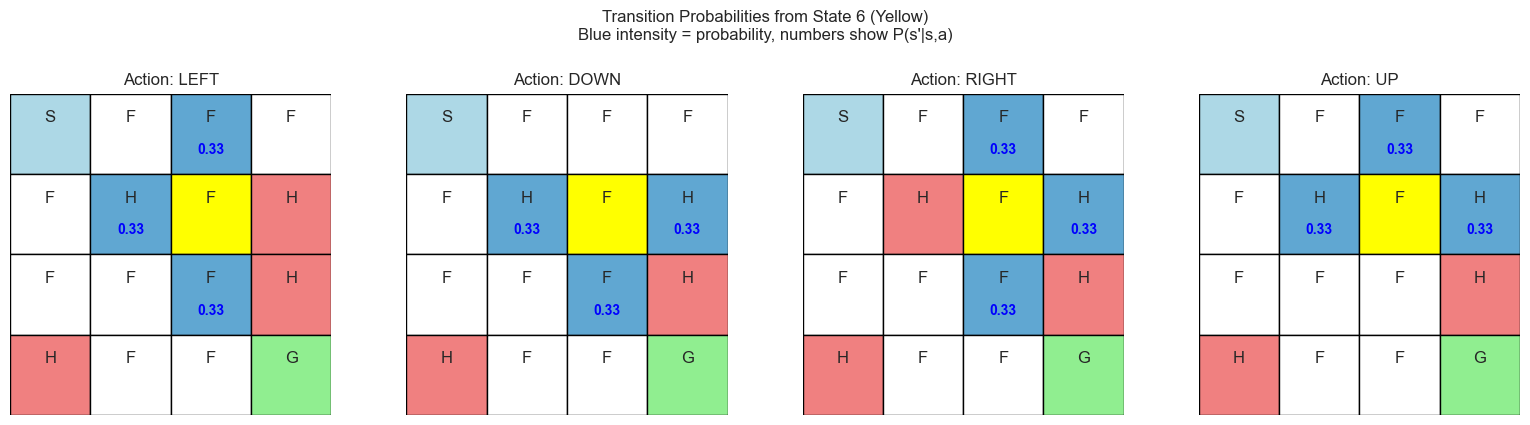

Notice: Due to slippery ice, the intended action only succeeds 1/3 of the time!
The other 2/3, the agent slips perpendicular to the intended direction.


In [16]:
# Visualize transition probabilities from one state for all actions
print("**Question this plot answers:** 'How does each action affect where I might end up?'\n")

def visualize_mdp_transitions(state, T, env):
    """Visualize transitions from a state for all actions."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    for action, ax in enumerate(axes):
        for i in range(nrow):
            for j in range(ncol):
                cell = desc[i, j]
                state_idx = i * ncol + j
                prob = T[state, action, state_idx]
                
                if state_idx == state:
                    facecolor = 'yellow'
                elif prob > 0:
                    facecolor = plt.cm.Blues(0.3 + 0.7 * prob)
                else:
                    facecolor = colors.get(cell, 'white')
                
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=facecolor, edgecolor='black')
                ax.add_patch(rect)
                
                ax.text(j + 0.5, nrow - 1 - i + 0.7, cell,
                       ha='center', va='center', fontsize=12)
                
                if prob > 0 and state_idx != state:
                    ax.text(j + 0.5, nrow - 1 - i + 0.3, f'{prob:.2f}',
                           ha='center', va='center', fontsize=10, 
                           color='blue', fontweight='bold')
        
        ax.set_xlim(0, ncol)
        ax.set_ylim(0, nrow)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(f'Action: {action_names[action]}')
    
    plt.suptitle(f'Transition Probabilities from State {state} (Yellow)\n'
                 f'Blue intensity = probability, numbers show P(s\'|s,a)', y=1.05)
    plt.tight_layout()
    return fig

visualize_mdp_transitions(6, T_mdp, env)
plt.show()

print("Notice: Due to slippery ice, the intended action only succeeds 1/3 of the time!")
print("The other 2/3, the agent slips perpendicular to the intended direction.")

### How to Read This Plot

**Understanding the visualization:**
- **Yellow square** = Current state (state 6 in this example)
- **Four panels** = One for each possible action (LEFT, DOWN, RIGHT, UP)
- **Numbers in cells** = Probability of transitioning to that state
- **Blue shading** = Possible destination states (darker = higher probability)

**Answering the question: "How does each action affect where I might end up?"**

Let's trace through a specific example to see how the slippery ice works:

**Example: Taking action RIGHT from state 6**
- Look at the "RIGHT" panel (third from left)
- You'll see three cells with probabilities:
  - State 7 (right of state 6): probability ≈ 0.33 — This is the *intended* direction
  - State 2 (above state 6): probability ≈ 0.33 — This is perpendicular to RIGHT (slipped UP)
  - State 10 (below state 6): probability ≈ 0.33 — This is perpendicular to RIGHT (slipped DOWN)

This matches the "1/3 intended, 2/3 perpendicular" mechanic:
- **1/3 of the time**: You successfully move RIGHT to state 7
- **1/3 of the time**: You slip perpendicular (UP) to state 2
- **1/3 of the time**: You slip perpendicular (DOWN) to state 10

**Try reading the other panels yourself:**
- What happens if you try to go LEFT from state 6?
- What happens if you try to go DOWN from state 6?
- Can you identify the intended direction vs. the perpendicular slips in each case?

This visualization format will appear throughout the tutorial, so understanding how to read it now will help you interpret future plots!

> **Checkpoint — You should now understand:**
> - An MDP adds actions to an MRP: $(S, A, P, R, \gamma)$
> - Transitions and rewards now depend on both state AND action
> - The agent actively chooses actions rather than following fixed behavior
> - In FrozenLake, the slippery ice makes transitions stochastic even with a chosen action

---

# 2. Policies in MDPs

**Policies Revisited: From General RL to MDPs**

In **Notebook 01_2**, you learned about policies in a general RL context: deterministic vs stochastic policies, the notation $\pi(a|s)$, and how agents use policies to select actions. Now we're revisiting policies, but with a crucial new perspective.

**Why revisit policies?** Because now we're viewing them through the lens of the **MDP framework**. This shift unlocks a powerful insight:

> **Key Insight:** When you fix a policy $\pi$ in an MDP, you get an MRP.
>
> **MDP + Policy = MRP**

Think about it: an MDP has actions and state-action transitions. But once you fix a policy ("I always take action $a$ in state $s$ with probability $\pi(a|s)$"), the action dimension collapses. You're back to a chain of states with fixed transition probabilities - that's an MRP!

**Why does this matter?** Because we just learned how to solve MRPs using the Bellman equation. If we can convert "MDP + policy" into an MRP, we can use those same tools to **evaluate** how good a policy is. That's exactly what we'll do next.

A **policy** $\pi$ defines the agent's behavior - how it chooses actions based on states.

$$\pi(a|s) = P[A_t = a | S_t = s]$$

**Plain English:** "The policy pi of action a given state s equals the probability that the action at time t is a, given that the state at time t is s."

**Formula components:**
- $\pi(a|s)$ = the policy function (read as "pi of a given s")
- $P[\cdot]$ = probability of the event in brackets
- $A_t$ = the action random variable at time step $t$
- $a$ = a specific action value
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value

## Types of Policies

**Deterministic Policy:** $a = \pi(s)$  
Always same action for a state  
*Example:* "In state 6, always go RIGHT"

**Stochastic Policy:** $\pi(a|s)$  
Probability distribution over actions  
*Example:* "In state 6: 40% RIGHT, 30% DOWN, "

## Key Insight: MDP + Policy = MRP

Once we fix a policy $\pi$, the MDP becomes an MRP!

- **Transitions**: $P^\pi_{ss'} = \sum_a \pi(a|s) P^a_{ss'}$
- **Rewards**: $R^\pi_s = \sum_a \pi(a|s) R^a_s$

**Transition plain English:** "The transition probability from s to s-prime under policy pi equals the sum over all actions of the policy probability times the action-specific transition probability."

**Formula components for transitions:**
- $P^\pi_{ss'}$ = the transition probability from $s$ to $s'$ under policy $\pi$ (read as "P super pi sub s s-prime")
- $\sum_a$ = the sum over all possible actions $a$
- $\pi(a|s)$ = the probability of taking action $a$ in state $s$ under policy $\pi$
- $P^a_{ss'}$ = the transition probability from $s$ to $s'$ when taking action $a$

**Reward plain English:** "The expected reward for state s under policy pi equals the sum over all actions of the policy probability times the action-specific reward."

**Formula components for rewards:**
- $R^\pi_s$ = the expected reward for state $s$ under policy $\pi$ (read as "R super pi sub s")
- $\sum_a$ = the sum over all possible actions $a$
- $\pi(a|s)$ = the probability of taking action $a$ in state $s$ under policy $\pi$
- $R^a_s$ = the expected reward for state $s$ when taking action $a$

The policy "averages out" the action choice, leaving us with state-to-state transitions.

In [17]:
# Define some policies for FrozenLake
n_states = env.observation_space.n
n_actions = env.action_space.n

# Uniform random policy
def create_uniform_policy():
    """Return a uniform random policy."""
    return np.ones((n_states, n_actions)) / n_actions

# "Go DOWN then RIGHT" policy
def create_down_right_policy():
    """Policy that prefers DOWN in upper half, RIGHT in lower half."""
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        row = s // 4
        if row < 2:  # Upper half: go DOWN
            policy[s, 1] = 1.0  # DOWN
        else:  # Lower half: go RIGHT
            policy[s, 2] = 1.0  # RIGHT
    return policy

pi_random = create_uniform_policy()
pi_down_right = create_down_right_policy()

print("Example Policies for FrozenLake")
print("=" * 50)

print("\nUniform Random Policy π_random(a|s=6):")
for a in range(n_actions):
    print(f"  π({action_names[a]}|s=6) = {pi_random[6, a]:.2f}")

print("\nDown-then-Right Policy π_dr(a|s=6):")
for a in range(n_actions):
    print(f"  π({action_names[a]}|s=6) = {pi_down_right[6, a]:.2f}")

Example Policies for FrozenLake

Uniform Random Policy π_random(a|s=6):
  π(LEFT|s=6) = 0.25
  π(DOWN|s=6) = 0.25
  π(RIGHT|s=6) = 0.25
  π(UP|s=6) = 0.25

Down-then-Right Policy π_dr(a|s=6):
  π(LEFT|s=6) = 0.00
  π(DOWN|s=6) = 1.00
  π(RIGHT|s=6) = 0.00
  π(UP|s=6) = 0.00


In [18]:
# Convert MDP + Policy to MRP
def mdp_to_mrp(T, R_sa, policy):
    """
    Convert MDP with policy to MRP.
    
    Args:
        T: Transition tensor T[s,a,s']
        R_sa: Reward matrix R[s,a]
        policy: Policy matrix π[s,a]
    
    Returns:
        P_mrp: MRP transition matrix P[s,s']
        R_mrp: MRP reward vector R[s]
    """
    n_states = T.shape[0]
    n_actions = T.shape[1]
    
    # P_ss'^π = Σ_a π(a|s) × P_ss'^a
    P_mrp = np.zeros((n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            P_mrp[s] += policy[s, a] * T[s, a]
    
    # R_s^π = Σ_a π(a|s) × R_s^a
    R_mrp = np.sum(policy * R_sa, axis=1)
    
    return P_mrp, R_mrp

# Convert with random policy
P_from_random, R_from_random = mdp_to_mrp(T_mdp, R_mdp, pi_random)
P_from_dr, R_from_dr = mdp_to_mrp(T_mdp, R_mdp, pi_down_right)

print("MDP + Policy → MRP")
print("=" * 50)
print(f"\nMDP: T shape = {T_mdp.shape}, R shape = {R_mdp.shape}")
print(f"\nWith Random Policy:")
print(f"  MRP: P shape = {P_from_random.shape}, R shape = {R_from_random.shape}")
print(f"\nWith Down-Right Policy:")
print(f"  MRP: P shape = {P_from_dr.shape}, R shape = {R_from_dr.shape}")
print(f"\nRow sums of P (should be 1): {P_from_random.sum(axis=1)[:4]}...")

MDP + Policy → MRP

MDP: T shape = (16, 4, 16), R shape = (16, 4)

With Random Policy:
  MRP: P shape = (16, 16), R shape = (16,)

With Down-Right Policy:
  MRP: P shape = (16, 16), R shape = (16,)

Row sums of P (should be 1): [1. 1. 1. 1.]...


> **Checkpoint — You should now understand:**
> - A policy $\pi(a|s)$ defines how the agent chooses actions
> - Policies can be deterministic or stochastic
> - MDP + fixed policy = MRP (the policy "collapses" the action dimension)

---
# 3. Value Functions for MDPs

## From MRPs to MDPs: Revisiting Value Functions

**You've seen value functions before!** In notebook 01_3, you learned about $V^\pi(s)$ and $Q^\pi(s,a)$ in the general RL context. Now we're going to see these same concepts through the **MDP framework lens**, which will let us derive powerful recursive equations (the Bellman equations).

**Let's connect the dots:**

1. **In Notebook 02_2 (MRPs):** You learned about $v(s)$ - the value function for a Markov Reward Process. Remember, MRPs have **no policy** because there are no actions to choose from. The agent just follows the transition probabilities $P$.

2. **In Section 2 (Policies):** You just learned a key insight: **MDP + Policy = MRP**. When you fix a policy $\pi$ in an MDP, the action dimension "collapses" - the agent's behavior becomes deterministic, creating an MRP.

3. **Now in Section 3:** We're defining $V^\pi(s)$ for MDPs. Here's the crucial connection: **$V^\pi(s)$ for an MDP is exactly the same as $v(s)$ for the MRP induced by policy $\pi$!** When you apply a policy to an MDP, you get an MRP, and the value function of that MRP is $V^\pi$.

**What's new in MDPs?**

Because MDPs have actions, we can define a **second type of value function** that doesn't exist in MRPs:
- **State-value function** $V^\pi(s)$: "How good is it to BE in state $s$?" (same as MRP's $v(s)$ for the induced MRP)
- **Action-value function** $Q^\pi(s,a)$: "How good is it to DO action $a$ in state $s$?" (**NEW!** Can't exist in MRPs because MRPs have no actions)

**Why does this matter?**

In the sections ahead, we'll derive **Bellman equations** for both $V^\pi$ and $Q^\pi$. These recursive relationships are the foundation for essentially all RL algorithms. Understanding how they connect to the simpler MRP value function will help you see the bigger picture.

In MDPs, we have two value functions that depend on the policy:

## State-Value Function $V^\pi(s)$

$$V^\pi(s) = \mathbb{E}_\pi[G_t | S_t = s]$$

**Plain English:** "The state-value under policy pi for state s equals the expected value of the return when following policy pi, given that the state at time t is s."

**Formula components:**
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$ (read as "V pi of s")
- $\mathbb{E}_\pi[\cdot]$ = the expected value (average) when following policy $\pi$
- $G_t$ = the return (total discounted reward) from time $t$ onwards
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value

**"How good is it to BE in state $s$ if I follow policy $\pi$?"**

## Action-Value Function $Q^\pi(s, a)$

$$Q^\pi(s, a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$$

**Plain English:** "The action-value under policy pi for state s and action a equals the expected value of the return when following policy pi, given that the state at time t is s and the action at time t is a."

**Formula components:**
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$ (read as "Q pi of s, a")
- $\mathbb{E}_\pi[\cdot]$ = the expected value (average) when following policy $\pi$
- $G_t$ = the return (total discounted reward) from time $t$ onwards
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value
- $A_t$ = the action random variable at time step $t$
- $a$ = a specific action value

**"How good is it to DO action $a$ in state $s$, then follow policy $\pi$?"**

## Comparison

| Aspect | $V^\pi(s)$ | $Q^\pi(s, a)$ |
|--------|-----------|---------------|
| **Input** | State only | State AND action |
| **Question** | "How good is this state?" | "How good is this action here?" |
| **Size (FrozenLake)** | 16 values | 64 values (16 × 4) |
| **Use** | Evaluate being in a state | Compare different actions |

In [19]:
# Compute V^π using MRP solution
def compute_V_pi(T, R_sa, policy, gamma):
    """Compute V^π using direct solution of Bellman equation."""
    P_mrp, R_mrp = mdp_to_mrp(T, R_sa, policy)
    n_states = len(R_mrp)
    I = np.eye(n_states)
    V = np.linalg.solve(I - gamma * P_mrp, R_mrp)
    return V

# Compute Q^π from V^π
def compute_Q_from_V(T, R_sa, V, gamma):
    """Compute Q^π from V^π."""
    n_states, n_actions = R_sa.shape
    Q = np.zeros((n_states, n_actions))
    
    for s in range(n_states):
        for a in range(n_actions):
            # Q(s,a) = R(s,a) + γ × Σ P(s'|s,a) × V(s')
            Q[s, a] = R_sa[s, a] + gamma * np.sum(T[s, a] * V)
    
    return Q

# Compute values for random policy
gamma = 0.99
V_random = compute_V_pi(T_mdp, R_mdp, pi_random, gamma)
Q_random = compute_Q_from_V(T_mdp, R_mdp, V_random, gamma)

print(f"Value Functions for Random Policy (γ = {gamma})")
print("=" * 55)
print("\nState-Value Function V^π(s):")
print(V_random.reshape(4, 4).round(4))

Value Functions for Random Policy (γ = 0.99)

State-Value Function V^π(s):
[[ 0.0124  0.0104  0.0193  0.0095]
 [ 0.0148  0.      0.0389  0.    ]
 [ 0.0326  0.0843  0.1378 -0.    ]
 [ 0.      0.1703  0.4336  0.    ]]


**Question this heatmap answers:** 'Under random policy, which states are most valuable?'



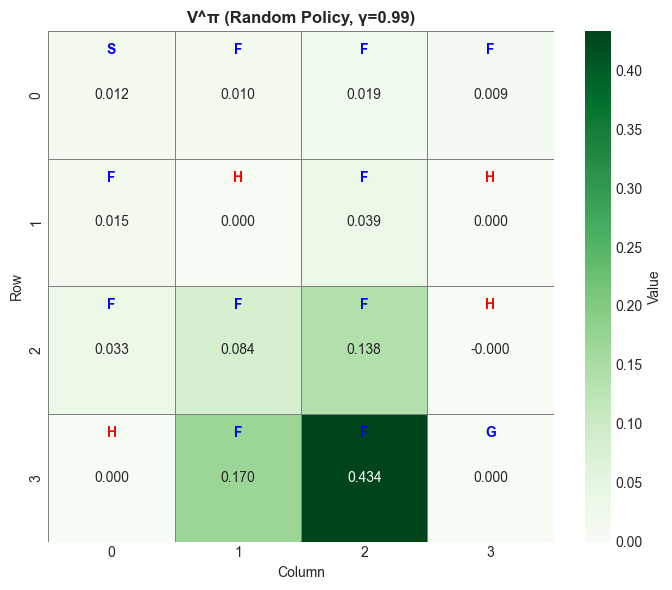

In [20]:
# Visualize V^π
print("**Question this heatmap answers:** 'Under random policy, which states are most valuable?'\n")

visualize_value_function(V_random, title=f"V^π (Random Policy, γ={gamma})")
plt.show()

**Question this plot answers:** 'Which action is best in each state under random policy?'



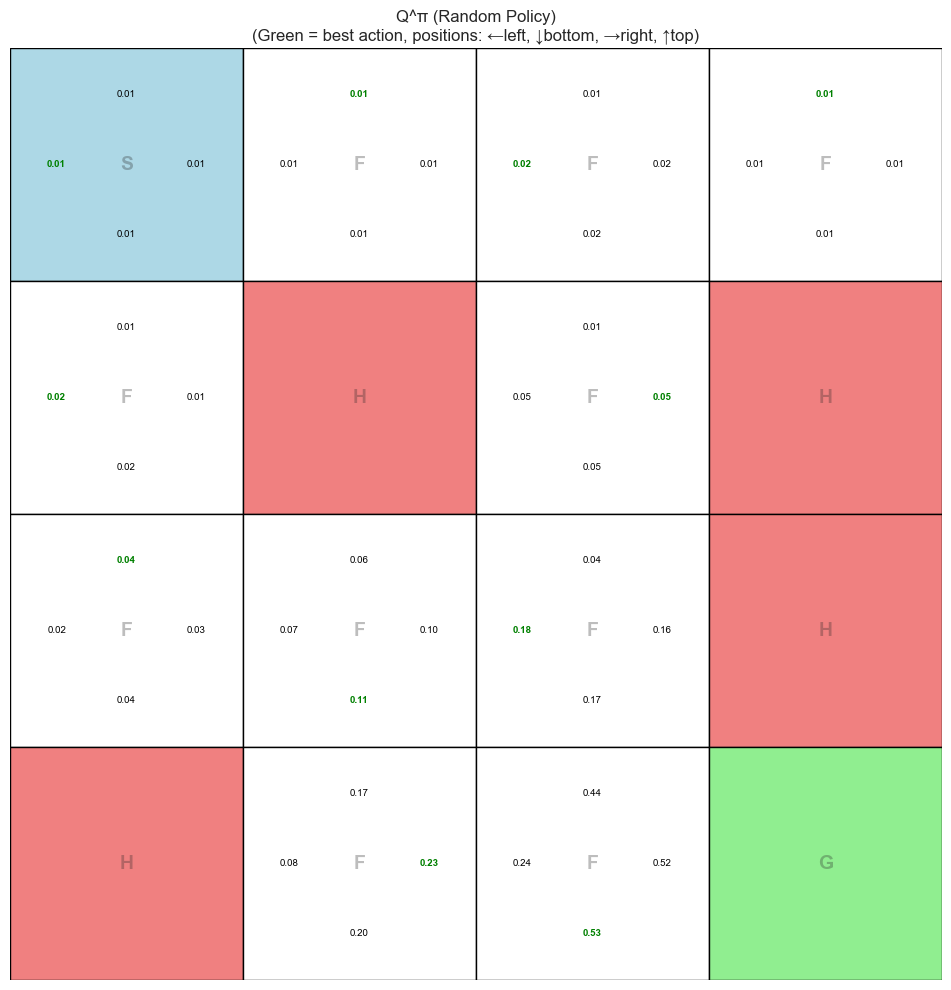

In [21]:
# Visualize Q^π values
print("**Question this plot answers:** 'Which action is best in each state under random policy?'\n")

def visualize_q_values(Q, env, title="Q-Values"):
    """Visualize Q-values showing best action in each state."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    action_arrows = ['←', '↓', '→', '↑']
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            cell = desc[i, j]
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=colors.get(cell, 'white'), edgecolor='black')
            ax.add_patch(rect)
            
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell, ha='center', va='center',
                   fontsize=14, fontweight='bold', alpha=0.3)
            
            if cell not in ['H', 'G']:
                best_action = np.argmax(Q[state])
                positions = [(0.2, 0.5), (0.5, 0.2), (0.8, 0.5), (0.5, 0.8)]  # L, D, R, U
                for a in range(4):
                    x, y = positions[a]
                    color = 'green' if a == best_action else 'black'
                    weight = 'bold' if a == best_action else 'normal'
                    ax.text(j + x, nrow - 1 - i + y, f'{Q[state, a]:.2f}',
                           ha='center', va='center', fontsize=7, 
                           color=color, fontweight=weight)
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"{title}\n(Green = best action, positions: ←left, ↓bottom, →right, ↑top)", fontsize=12)
    
    plt.tight_layout()
    return fig, ax

visualize_q_values(Q_random, env, title="Q^π (Random Policy)")
plt.show()

### How to Read This Q-Values Plot

**Understanding the visualization:**
- Each grid cell shows **four Q-values** positioned around the cell type letter (S, F, H, G)
- **Positions** correspond to actions: left side = LEFT, bottom = DOWN, right side = RIGHT, top = UP
- **Green bold text** = highest Q-value (best action in that state)
- **Black text** = other Q-values (suboptimal actions)
- Holes (H) and Goal (G) have no Q-values shown (terminal states)

**What the Q-values mean:**

Each Q-value $Q^\pi(s,a)$ answers: "*If I take action $a$ in state $s$, then follow the random policy, what's my expected total discounted reward?*"

**Concrete calculation example for State 10:**

Let's verify how $Q^\pi(10, \text{RIGHT}) = 0.16$ was calculated (shown on the right side of state 10's cell):

Using the Bellman equation: $Q^\pi(s,a) = R^a_s + \gamma \sum_{s'} P^a_{ss'} V^\pi(s')$

**Step 1: Immediate reward**
- $R^{\text{RIGHT}}_{10} = 0$ (no immediate reward for moving from state 10)

**Step 2: Future value from possible next states**

When taking RIGHT from state 10, you can slip to three possible next states:
- State 6 (above): $P = 0.33$, $V^\pi(6) = 0.0389$
- State 11 (right, a Hole): $P = 0.33$, $V^\pi(11) = 0.0000$  
- State 14 (below, near Goal): $P = 0.33$, $V^\pi(14) = 0.4336$

Future value = $\gamma \times [0.33 \times 0.0389 + 0.33 \times 0.0000 + 0.33 \times 0.4336]$
             = $0.99 \times [0.0128 + 0.0000 + 0.1431]$
             = $0.99 \times 0.1559$
             = $0.1554$

**Step 3: Total Q-value**

$Q^\pi(10, \text{RIGHT}) = 0 + 0.1554 \approx 0.16$ ✓

**Why is RIGHT the best action in state 10?**

Compare all four Q-values for state 10:
- LEFT: 0.18 (best! Can reach state 9 which is closer to goal)
- DOWN: 0.17 (second best)
- RIGHT: 0.16 (third)
- UP: 0.04 (worst, might reach holes above)

Even though we're following a *random policy* (all actions equally likely), the Q-values tell us which actions lead to better outcomes on average. This insight is what we'll use later to *improve* the policy!

## Relationship Between V and Q

**Recall from Notebook 01_3:** The two value functions are related by the equation:

$$V^\pi(s) = \sum_a \pi(a|s) \cdot Q^\pi(s, a)$$

V is the weighted average of Q values, weighted by the policy probabilities.

The code below verifies this relationship holds in our MDP:

In [22]:
# Verify V = Σ π(a|s) × Q(s,a)
state = 10

print(f"Verifying V = Σ π(a|s) × Q(s,a) for State {state}")
print("=" * 55)

V_direct = V_random[state]
print(f"\nDirect V^π({state}) = {V_direct:.6f}")

print(f"\nUsing V = Σ π(a|s) × Q(s,a):")
V_from_Q = 0
for a in range(n_actions):
    contribution = pi_random[state, a] * Q_random[state, a]
    V_from_Q += contribution
    print(f"  π({action_names[a]}|{state}) × Q({state},{action_names[a]}) = {pi_random[state,a]:.2f} × {Q_random[state,a]:.4f} = {contribution:.6f}")

print(f"\nSum = {V_from_Q:.6f}")
print(f"\n✓ Verified!" if abs(V_direct - V_from_Q) < 1e-6 else "✗ Error!")

Verifying V = Σ π(a|s) × Q(s,a) for State 10

Direct V^π(10) = 0.137811

Using V = Σ π(a|s) × Q(s,a):
  π(LEFT|10) × Q(10,LEFT) = 0.25 × 0.1837 = 0.045937
  π(DOWN|10) × Q(10,DOWN) = 0.25 × 0.1709 = 0.042728
  π(RIGHT|10) × Q(10,RIGHT) = 0.25 × 0.1559 = 0.038979
  π(UP|10) × Q(10,UP) = 0.25 × 0.0407 = 0.010167

Sum = 0.137811

✓ Verified!


> **Checkpoint — You should now understand:**
> - $V^\pi(s)$: expected return starting from state $s$ under policy $\pi$
> - $Q^\pi(s, a)$: expected return after taking action $a$ in state $s$, then following $\pi$
> - $V^\pi(s) = \sum_a \pi(a|s) Q^\pi(s, a)$ — V is the policy-weighted average of Q

---
# 4. Bellman Expectation Equations

## From MRP Bellman Equation to MDP Bellman Equations

**You've seen a Bellman equation before!** In **Notebook 02_2 (MRPs)**, you learned the Bellman equation for Markov Reward Processes:

$$v(s) = R_s + \gamma \sum_{s'} P_{ss'} v(s')$$

That equation had no actions because MRPs have no choices. Now in MDPs, we add actions, which creates **two key differences**:

1. **Transitions and rewards depend on actions**: Instead of just $P_{ss'}$ and $R_s$, we now have $P^a_{ss'}$ and $R^a_s$
2. **We need to account for the policy**: The agent follows policy $\pi(a|s)$, so we must average over actions

**The result**: MRP's single Bellman equation becomes MDP's **two Bellman expectation equations** - one for $V^\pi(s)$ and one for $Q^\pi(s,a)$.


The Bellman equations express the **recursive relationship** between value functions.

## Intuition: Value = Immediate + Future

The value of a state (or state-action pair) can be decomposed:

**Value now = What I get now + (Discounted) What I expect later**

## Bellman Expectation Equation for $V^\pi$

$$V^\pi(s) = \sum_a \pi(a|s) \left[ R^a_s + \gamma \sum_{s'} P^a_{ss'} V^\pi(s') \right]$$

**Plain English:** "The state-value of s under policy pi equals the sum over all actions of the policy probability times the quantity in brackets, where the brackets contain the reward plus gamma times the sum over next states of the transition probability times the next state value."

**Formula components:**
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$
- $\sum_a$ = the sum over all possible actions $a$
- $\pi(a|s)$ = the probability of taking action $a$ in state $s$ under policy $\pi$
- $[\cdot]$ = the brackets group the immediate and future components
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $V^\pi(s')$ = the state-value function for the next state $s'$ under policy $\pi$

Breaking this down:
1. $\sum_a \pi(a|s)$ — average over actions according to policy
2. $R^a_s$ — immediate reward for taking action $a$
3. $\gamma \sum_{s'} P^a_{ss'} V^\pi(s')$ — discounted expected value of next states

## Bellman Expectation Equation for $Q^\pi$

$$Q^\pi(s, a) = R^a_s + \gamma \sum_{s'} P^a_{ss'} V^\pi(s')$$

**Plain English:** "The action-value of taking action a in state s under policy pi equals the reward plus gamma times the sum over next states of the transition probability times the next state value."

**Formula components:**
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $V^\pi(s')$ = the state-value function for the next state $s'$ under policy $\pi$

Or equivalently, substituting $V$:

$$Q^\pi(s, a) = R^a_s + \gamma \sum_{s'} P^a_{ss'} \sum_{a'} \pi(a'|s') Q^\pi(s', a')$$

**Plain English:** "The action-value of taking action a in state s under policy pi equals the reward plus gamma times the sum over next states of the transition probability times the sum over next actions of the policy probability times the next action-value."

**Formula components:**
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $\sum_{a'}$ = the sum over all possible next actions $a'$ (in the next state)
- $\pi(a'|s')$ = the probability of taking action $a'$ in the next state $s'$ under policy $\pi$
- $Q^\pi(s', a')$ = the action-value function for the next state $s'$ and next action $a'$ under policy $\pi$

In [23]:
# Verify Bellman Expectation Equation for V^π
state = 10
gamma = 0.99

print(f"Verifying Bellman Expectation Equation for V^π at State {state}")
print("=" * 65)
print(f"\nEquation: V^π(s) = Σ_a π(a|s) × [R(s,a) + γ × Σ_s' P(s'|s,a) × V^π(s')]")

V_direct = V_random[state]
print(f"\nDirect solution: V^π({state}) = {V_direct:.6f}")

print(f"\nUsing Bellman equation:")
V_bellman = 0
for a in range(n_actions):
    # Immediate reward + discounted future value
    immediate = R_mdp[state, a]
    future = gamma * np.sum(T_mdp[state, a] * V_random)
    q_sa = immediate + future
    
    contribution = pi_random[state, a] * q_sa
    V_bellman += contribution
    
    print(f"  a={action_names[a]}: π={pi_random[state,a]:.2f} × [R={immediate:.4f} + γ×ΣPV={future:.4f}] = {contribution:.6f}")

print(f"\nSum = {V_bellman:.6f}")
print(f"\n✓ Bellman equation verified!" if abs(V_direct - V_bellman) < 1e-6 else "✗ Error!")

Verifying Bellman Expectation Equation for V^π at State 10

Equation: V^π(s) = Σ_a π(a|s) × [R(s,a) + γ × Σ_s' P(s'|s,a) × V^π(s')]

Direct solution: V^π(10) = 0.137811

Using Bellman equation:
  a=LEFT: π=0.25 × [R=0.0000 + γ×ΣPV=0.1837] = 0.045937
  a=DOWN: π=0.25 × [R=0.0000 + γ×ΣPV=0.1709] = 0.042728
  a=RIGHT: π=0.25 × [R=0.0000 + γ×ΣPV=0.1559] = 0.038979
  a=UP: π=0.25 × [R=0.0000 + γ×ΣPV=0.0407] = 0.010167

Sum = 0.137811

✓ Bellman equation verified!


In [24]:
# Verify Bellman Expectation Equation for Q^π
state = 10
action = 2  # RIGHT

print(f"Verifying Bellman Expectation Equation for Q^π at State {state}, Action {action_names[action]}")
print("=" * 70)
print(f"\nEquation: Q^π(s,a) = R(s,a) + γ × Σ_s' P(s'|s,a) × V^π(s')")

Q_direct = Q_random[state, action]
print(f"\nDirect solution: Q^π({state},{action_names[action]}) = {Q_direct:.6f}")

print(f"\nUsing Bellman equation:")
print(f"  R({state},{action_names[action]}) = {R_mdp[state, action]:.6f}")

future_value = 0
print(f"\n  γ × Σ P(s'|s,a) × V^π(s'):")
for next_s in range(n_states):
    if T_mdp[state, action, next_s] > 0:
        contribution = T_mdp[state, action, next_s] * V_random[next_s]
        future_value += contribution
        print(f"    P({next_s}|{state},{action_names[action]}) × V({next_s}) = {T_mdp[state,action,next_s]:.2f} × {V_random[next_s]:.4f} = {contribution:.6f}")

print(f"\n  Σ = {future_value:.6f}")
print(f"  γ × Σ = {gamma * future_value:.6f}")

Q_bellman = R_mdp[state, action] + gamma * future_value
print(f"\nQ^π({state},{action_names[action]}) = {R_mdp[state,action]:.6f} + {gamma * future_value:.6f} = {Q_bellman:.6f}")
print(f"\n✓ Bellman equation verified!" if abs(Q_direct - Q_bellman) < 1e-6 else "✗ Error!")

Verifying Bellman Expectation Equation for Q^π at State 10, Action RIGHT

Equation: Q^π(s,a) = R(s,a) + γ × Σ_s' P(s'|s,a) × V^π(s')

Direct solution: Q^π(10,RIGHT) = 0.155916

Using Bellman equation:
  R(10,RIGHT) = 0.000000

  γ × Σ P(s'|s,a) × V^π(s'):
    P(6|10,RIGHT) × V(6) = 0.33 × 0.0389 = 0.012965
    P(11|10,RIGHT) × V(11) = 0.33 × -0.0000 = -0.000000
    P(14|10,RIGHT) × V(14) = 0.33 × 0.4336 = 0.144526

  Σ = 0.157491
  γ × Σ = 0.155916

Q^π(10,RIGHT) = 0.000000 + 0.155916 = 0.155916

✓ Bellman equation verified!


> **Checkpoint — You should now understand:**
> - Bellman equations express value recursively: Value = Immediate + γ × Expected Future
> - For $V^\pi$: average over actions, then over next states
> - For $Q^\pi$: immediate reward + discounted expected next state value
> - These equations are the foundation for RL algorithms

---
# 5. Summary and Concept Map

In this notebook, we added actions to MRPs, creating the full MDP framework:

## Key Concepts

- **MDP**: Markov Chain + Actions (S, A, P, R, γ)
- **Policy π(a|s)**: Defines how agent chooses actions in each state
- **MDP + Policy = MRP**: Fixing policy collapses action dimension
- **V^π(s)**: Expected return from state s under policy π
- **Q^π(s,a)**: Expected return from taking action a in state s under π
- **Bellman Expectation**: Recursive equations for policy evaluation


```
FROM MRP TO MDP: ADDING ACTIONS
================================

MARKOV CHAIN (Part 02_1)
   (S, P)
   ↓
   + Rewards
   ↓
MARKOV REWARD PROCESS (Part 02_2)
   (S, P, R, γ)
   ↓
   + Actions
   ↓
MARKOV DECISION PROCESS (Part 02_3)
   (S, A, P, R, γ)


KEY RELATIONSHIPS
=================

MDP + Policy π → MRP
────────────────────
  P^π_{ ss'} = Σ_a π(a|s) × P^a_{ss'}
  R^π_s = Σ_a π(a|s) × R^a_s


V^π and Q^π Relationship
────────────────────────
  V^π(s) = Σ_a π(a|s) × Q^π(s,a)
  (V is policy-weighted average of Q values)


BELLMAN EXPECTATION EQUATIONS
==============================

For V^π:
  V^π(s) = Σ_a π(a|s) × [R^a_s + γ Σ_{s'} P^a_{ss'} V^π(s')]
           └──────────┘   └──────────────────────────────┘
         policy average    immediate + future

For Q^π:
  Q^π(s,a) = R^a_s + γ Σ_{s'} P^a_{ss'} V^π(s')
             └───┘   └────────────────────────┘
           immediate      future
```

## What's Coming Next

In **Part 2.4 (Optimal Policies)**, we'll learn how to find the **best** policy:
- Optimal value functions $V^*(s)$ and $Q^*(s,a)$
- Bellman optimality equations (using $\max$ instead of $\sum_a \pi(a|s)$)
- Finding optimal policies: $\pi^*(s) = \arg\max_a Q^*(s,a)$
- Why optimality equations are non-linear and require iterative methods


---
# 6. Your Turn

## Exercise 1: MDP vs MRP

**Question:** What's the fundamental difference between an MDP and an MRP? Why can't we use MRPs for reinforcement learning?

<details>
<summary>Click to see hint</summary>

Think about what "learning" means in RL. What does the agent need to improve?

</details>

<details>
<summary>Click to see answer</summary>

**The fundamental difference is CHOICE:**

**MRP:**
- No actions → No choices
- Agent passively follows fixed transition probabilities $P_{ss'}$
- Can evaluate "how good is this chain?" but cannot improve it
- Like watching a movie - you observe but don't influence

**MDP:**
- Has actions → Agent makes choices
- Transitions depend on actions: $P^a_{ss'}$
- Agent can learn which actions lead to better outcomes
- Like playing a video game - your decisions matter

**Why MRPs aren't enough for RL:**

Reinforcement learning is about learning to make better decisions through experience. Without actions (choices), there's nothing to learn to improve! An MRP is useful for **prediction** (evaluating a fixed process) but not for **control** (improving behavior).

The policy $\pi$ is what the agent learns/improves in RL, and policies only exist when there are actions to choose from.

</details>

## Exercise 2: Bellman Expectation Verification

**Task:** Verify the Bellman expectation equation for $V^\pi$ at a different state (try state 6).

Use the code pattern from the notebook:
1. Look up the direct solution $V^\pi(6)$
2. Compute the right-hand side: $\sum_a \pi(a|6) \times [R(6,a) + \gamma \sum_{s'} P(s'|6,a) \times V^\pi(s')]$
3. Verify they match

**Question:** Why might state 6 have a different value than state 10, even though both are non-terminal frozen tiles?


In [ ]:
# YOUR CODE HERE
# Verify Bellman expectation equation for state 6

# state = 6
# gamma = 0.99

# print(f"Verifying Bellman Expectation for V^π at State {state}")
# print("=" * 60)

# # Direct solution
# V_direct = V_random[state]
# print(f"Direct: V^π({state}) = {V_direct:.6f}")

# # Bellman equation
# V_bellman = 0
# for a in range(n_actions):
#     immediate = R_mdp[state, a]
#     future = gamma * np.sum(T_mdp[state, a] * V_random)
#     contribution = pi_random[state, a] * (immediate + future)
#     V_bellman += contribution
#     print(f"  Action {a}: π={pi_random[state,a]:.2f} × [{immediate:.4f} + {gamma}×{future:.4f}] = {contribution:.6f}")

# print(f"\nBellman: V^π({state}) = {V_bellman:.6f}")
# print(f"Match: {abs(V_direct - V_bellman) < 1e-6}")

---

**Congratulations! You've completed Part 2.3 of the RL Tutorial!**

Key takeaways:
- MDPs add actions to MRPs, creating the full RL framework: (S, A, P, R, γ)
- Policies define how agents choose actions: π(a|s)
- MDP + Policy = MRP (the policy "collapses" the action dimension)
- V^π(s) evaluates states under a policy, Q^π(s,a) evaluates state-action pairs
- Bellman expectation equations relate values recursively for a given policy

**What's Next:**

In **Part 2.4 (Optimal Policies)**, we'll discover how to find the **best** policy:
- Optimal value functions V*(s) and Q*(s,a)
- Bellman optimality equations
- Finding optimal policies

Next: [02_4_optimal_policies.ipynb](02_4_optimal_policies.ipynb)